# Addressing the Problem

### Skin Disease Classification

The U.S. Census Bureau projects that by 2050, about half of all patients seen in the U.S. healthcare system will have skin of color (SOC). As these communities continue to grow, so will the likelihood of dermatologists encountering cutaneous (skin) diseases that happen more frequently in SOC patients, happen exclusively in SOC patients, and/or present differently in SOC patients than their White counterparts. Aiding dermatologists in their understanding, and more importantly diagnoses, of SOC patients’ cutaneous disease presentations is paramount to delivering life-saving
quality of care to these communities. As a result, the following practicum project will explore the use of computer vision for classification of cutaneous diseases in SOC patients.

### Problem Structure

The following research notebook addresses the supervised classification problem of determining whether a given image of a skin disease is benign (0) or malignant (1). The metric(s) to be used for evaluating the neural network's performance is TBD.

### Import Necessary Modules

In [1]:
# Python libraries
import shutil
import os
from IPython.display import display
from PIL import Image

# Data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Neural network libraries
import tensorflow as tf
from keras import utils, models, layers, optimizers, preprocessing

# AWS libraries
import boto3

2024-04-10 23:14:51.346530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Retrieval

My dataset of choice is the Diverse Dermatology Images (DDI) dataset curated by the Stanford University School of Medicine. As can be seen below, we begin by fetching the metadata CSV from the appropriate S3 location. The data workflow pipeline has already run the metadata transform Glue job on the raw metadata prior to the execution of this notebook, so we're merely fetching the cleaned product. However, further feature engineering will be performed on the metadata and images in preparation for model fitting.

Upon further inspection of the metadata, we can also see that it contains 656 fully-populated records, two of which being integer features and the other two being string features.

### Data Fetch

In [2]:
def download_s3_images(images_file_key):  
    for image_file_name in ddi_df['DDI_file'].tolist():    
        output_path = 'images/{}'.format(image_file_name)
        
        with open(output_path, 'wb') as image_output:
            s3.download_fileobj(
                Bucket=bucket, 
                Key='{}/{}'.format(images_file_key, image_file_name),
                Fileobj=image_output
            )

In [3]:
s3 = boto3.client('s3')
bucket = 'poc-skin-disease-detection-cv'

In [4]:
data_file_key = 'ddidiversedermatologyimages/metadata/transform'
data_file_name = 'part-00000-f5ce70f1-c572-4cbc-818e-e8dda587c3ef-c000.csv'

obj = s3.get_object(Bucket=bucket, Key='{}/{}'.format(data_file_key, data_file_name)) 
ddi_df = pd.read_csv(obj['Body'])

In [5]:
ddi_df.head()

,DDI_file,skin_tone,malignant,disease
0,000001.png,56,1,melanoma-in-situ
1,000002.png,56,1,melanoma-in-situ
2,000003.png,56,1,mycosis-fungoides
3,000004.png,56,1,squamous-cell-carcinoma-in-situ
4,000005.png,12,1,basal-cell-carcinoma


In [6]:
if not os.path.exists('images/'):
    os.mkdir('images')
    download_s3_images(images_file_key='ddidiversedermatologyimages/images')

### Data Inspection

In [7]:
ddi_df.shape

(656, 4)

In [8]:
ddi_df.dtypes

DDI_file     object
skin_tone     int64
malignant     int64
disease      object
dtype: object

In [9]:
ddi_df.isnull().sum()

DDI_file     0
skin_tone    0
malignant    0
disease      0
dtype: int64

In [10]:
ddi_df.describe()

,skin_tone,malignant
count,656.000000,656.000000
mean,33.966463,0.260671
std,17.511578,0.439336
min,12.000000,0.000000
25%,12.000000,0.000000
50%,34.000000,0.000000
75%,56.000000,1.000000
max,56.000000,1.000000


# Exploratory Data Analysis (EDA)

### Which cutaneous diseases comprise our dataset?

The initial scope of this project was to specifically assess melanomas. However, a total of 78 cutaneous disease presentations, including other well-known cutaneous conditions such as carcinomas, have been aggregated to form the DDI dataset.

In [11]:
print("Number of disease presentations: ", len(ddi_df['disease'].unique()))
np.sort(ddi_df['disease'].unique())

Number of disease presentations:  78


array(['abrasions-ulcerations-and-physical-injuries', 'abscess',
       'acne-cystic', 'acquired-digital-fibrokeratoma',
       'acral-melanotic-macule', 'acrochordon', 'actinic-keratosis',
       'angioleiomyoma', 'angioma', 'arteriovenous-hemangioma',
       'atypical-spindle-cell-nevus-of-reed', 'basal-cell-carcinoma',
       'basal-cell-carcinoma-nodular', 'basal-cell-carcinoma-superficial',
       'benign-keratosis', 'blastic-plasmacytoid-dendritic-cell-neoplasm',
       'blue-nevus', 'cellular-neurothekeoma', 'chondroid-syringoma',
       'clear-cell-acanthoma', 'coccidioidomycosis',
       'condyloma-accuminatum', 'dermatofibroma', 'dermatomyositis',
       'dysplastic-nevus', 'eccrine-poroma',
       'eczema-spongiotic-dermatitis', 'epidermal-cyst',
       'epidermal-nevus', 'fibrous-papule', 'focal-acral-hyperkeratosis',
       'folliculitis', 'foreign-body-granuloma', 'glomangioma',
       'graft-vs-host-disease', 'hematoma', 'hyperpigmentation',
       'inverted-follicular-k

### Which skin tones are present in this dataset?

What makes the DDI dataset unique is its inclusion of skin types across the skin tone spectrum. The skin tone index values below are representations of the Fitzpatrick Skin Types (FST): fairer skin tones (Types 1-2), medium skin tones (Types 3-4), and darker skin tones (Types 5-6). Given the record counts associated with each FST, we can conclude that the dataset samples are relatively balanced.

In [12]:
ddi_df.drop(['DDI_file', 'malignant'], axis=1).groupby(['skin_tone']).count()

,disease
skin_tone,
12,208
34,241
56,207


### What is the dataset's target variable distribution?

As was mentioned in the opening section, a skin disease presentation can be classified as either benign (0) or malignant (1); this is our dataset's target variable. Based on the data presented below, we can see that approximately 1 in 4 (26.1%) presentations will be malignant, a probability we should keep in mind when evaluating the classifications generated by the selected neural network. Additionally, we can see the classes are relatively balanced in their distribution across the FSTs, so no data resampling should be necessary.

In [13]:
pd.concat([ddi_df['malignant'].value_counts(), ddi_df['malignant'].value_counts(normalize=True)], axis=1)

,count,proportion
malignant,,
0,485,0.739329
1,171,0.260671


In [14]:
ddi_df.drop('DDI_file', axis=1).groupby(['malignant', 'skin_tone']).count()

disease
malignant skin_tone         
0         12             159
          34             167
          56             159
1         12              49
          34              74
          56              48

# Feature Engineering & Analysis

### Data Augmentation

In [15]:
def augment_images(df, num_augs):
      for i in range(num_augs):
        aug_iter = i+1
        
        for filename in df['DDI_file']:
            img = Image.open('images/{}'.format(filename)).rotate(90*aug_iter, expand=True)
            img.save('images/rand{}_{}'.format(aug_iter, filename))

In [16]:
def augment_metadata(df, num_augs):
    orig_size = len(df)
    
    for i in range(num_augs):
        aug_iter = i+1
        
        df_dupe = df.iloc[:orig_size]
        df_dupe['DDI_file'] = df_dupe['DDI_file'].apply(lambda x: 'rand{}_{}'.format(aug_iter, x))
        df = pd.concat([df, df_dupe])
        df.index = range(len(df))

    return df

In [17]:
num_augs = 3

if len(os.listdir('images/')) == len(ddi_df):
    augment_images(ddi_df, num_augs)

ddi_df = augment_metadata(ddi_df, num_augs)

/tmp/ipykernel_8010/2880849854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dupe['DDI_file'] = df_dupe['DDI_file'].apply(lambda x: 'rand{}_{}'.format(aug_iter, x))


### Creating Dataset Partitions

In [18]:
def generate_train_dataset(df, data_split):
    return preprocessing.image.ImageDataGenerator().flow_from_dataframe(
        df,
        directory='images/{}/'.format(data_split),
        x_col='DDI_file',
        y_col='malignant',
        target_size=(img_height, img_width),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        interpolation='lanczos',
    )

In [19]:
def generate_test_dataset():
    return utils.image_dataset_from_directory(
        directory='images/test/',
        labels=label_splits['test'].tolist(),
        label_mode='binary',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        interpolation='lanczos3',
        shuffle=True,
    )

In [20]:
X = ddi_df.drop('malignant', axis=1)
y = ddi_df['malignant']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.6, random_state=42,
                                                            stratify=pd.concat([y, X['skin_tone']], axis=1))

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42,
                                                stratify=pd.concat([y_val_test, X_val_test['skin_tone']], axis=1))

In [21]:
data_splits = {
    'train': X_train,
    'val': X_val,
    'test': X_test,
}
label_splits = {
    'train': y_train,
    'val': y_val,
    'test': y_test,
}

In [22]:
for split in data_splits.keys():
    if not os.path.exists('images/{}/'.format(split)):
        os.mkdir('images/{}'.format(split))
    
        for filename in data_splits[split]['DDI_file']:
            shutil.move('images/{}'.format(filename), 'images/{}/{}'.format(split, filename))

Text(0, 0.5, 'Pixel Height')

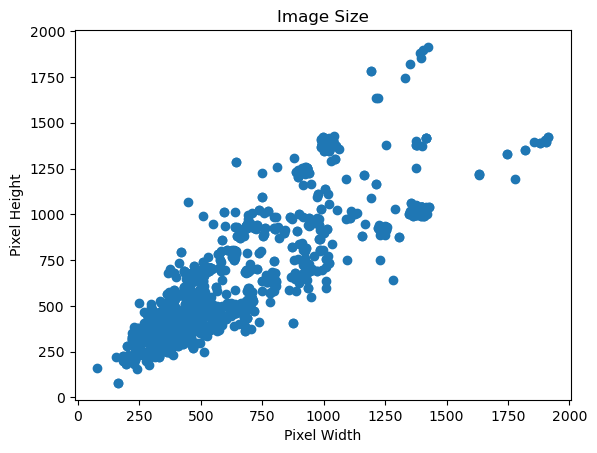

In [23]:
img_dims = pd.DataFrame(columns=['height', 'width'])

for split in data_splits.keys():
    for i, image_file_name in enumerate(data_splits[split]['DDI_file']):
        img = Image.open('images/{}/{}'.format(split, image_file_name))
        width, height = img.size
        img_dims.loc[i] = [height, width]

plt.scatter(img_dims['width'], img_dims['height'])
plt.title('Image Size')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')

In [24]:
batch_size = 32
img_height, img_width, img_channels = 256, 256, 3

In [25]:
ddi_df_train = pd.concat([X_train, y_train.astype(str)], axis=1)
images_train_ds = generate_train_dataset(ddi_df_train, 'train')

Found 1574 validated image filenames belonging to 2 classes.


In [26]:
ddi_df_val = pd.concat([X_val, y_val.astype(str)], axis=1)
images_val_ds = generate_train_dataset(ddi_df_val, 'val')

Found 525 validated image filenames belonging to 2 classes.


In [27]:
images_test_ds = generate_test_dataset()

Found 525 files belonging to 2 classes.


# Model Architecture

https://www.tensorflow.org/tutorials/load_data/images

In [28]:
epochs = 10

In [29]:
model = tf.keras.Sequential([
    tf.keras.Input((img_height, img_width, img_channels)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics='accuracy',
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

# Model Evaluation

In [31]:
model.fit(
    images_train_ds,#.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    validation_data=images_val_ds,#.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=epochs,
)

Epoch 1/10


2024-04-10 23:14:56.128329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.7300

2024-04-10 23:15:46.760504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 63s 1s/step - loss: 0.5913 - accuracy: 0.7300 - val_loss: 0.5839 - val_accuracy: 0.7390
Epoch 2/10
50/50 [==============================] - 57s 1s/step - loss: 0.5802 - accuracy: 0.7389 - val_loss: 0.5814 - val_accuracy: 0.7390
Epoch 3/10
50/50 [==============================] - 57s 1s/step - loss: 0.5781 - accuracy: 0.7389 - val_loss: 0.5976 - val_accuracy: 0.7390
Epoch 4/10
50/50 [==============================] - 57s 1s/step - loss: 0.5690 - accuracy: 0.7389 - val_loss: 0.5743 - val_accuracy: 0.7390
Epoch 5/10
50/50 [==============================] - 57s 1s/step - loss: 0.5551 - accuracy: 0.7395 - val_loss: 0.5862 - val_accuracy: 0.7390
Epoch 6/10
50/50 [==============================] - 57s 1s/step - loss: 0.5452 - accuracy: 0.7408 - val_loss: 0.5643 - val_accuracy: 0.7352
Epoch 7/10
50/50 [==============================] - 58s 1s/step - loss: 0.5258 - accuracy: 0.7497 - val_loss: 0.5693 - val_accuracy: 0.7352
Epoch 8/10
50/50 [=============

In [32]:
y_preds = model.predict(images_test_ds)

2024-04-10 23:24:35.951888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [525]
	 [[{{node Placeholder/_0}}]]
2024-04-10 23:24:35.952314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [525]
	 [[{{node Placeholder/_4}}]]


17/17 [==============================] - 4s 174ms/step


In [33]:
y_preds[y_preds >= 0.5]

array([0.61755747, 0.63921934, 0.6259197 , 0.50200707, 0.5481336 ,
       0.579747  , 0.52667   , 0.51574135, 0.5786261 , 0.50822246,
       0.5723415 ], dtype=float32)

# Future Work